In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import logistic

## Overview

In this notebook we briefly introduce the dataset and the base model used.

## Dataset

The data is FIDE chess games from around 2011 to 2019 based on tournaments occurring every 2 years. We know the identity of each player (i.e. `1503014` is [Magnus Carlsen](https://ratings.fide.com/profile/1503014)), their [Elo rating](https://en.wikipedia.org/wiki/Elo_rating_system) at the time of the game, their title and the game outcome. 

We ignore the title for our purposes as it's very unlikely to convey any information that isn't contained within the Elo rating.

In [2]:
df = pd.read_csv("../data/games.csv", parse_dates=["date"])

df.head(5)

,date,round,white_id,black_id,white_elo,black_elo,white_title,black_title,result
0,2019-09-10,1.1,9100075,8603677,1954.0,2811.0,FM,GM,0-1
1,2019-09-10,1.1,24116068,10207791,2780.0,2250.0,GM,FM,1-0
2,2019-09-10,1.1,8504580,623539,2284.0,2774.0,IM,GM,0-1
3,2019-09-10,1.1,5202213,6501311,2767.0,2387.0,GM,IM,1-0
4,2019-09-10,1.1,4902980,4168119,2407.0,2776.0,NaN,GM,0-1


## Model

The main model we will refer to can be viewed [here](../stan_models/ordered_logistic.stan). It models the 3 (ordered) outcomes of win, draw or lose using an [ordered logistic distribution](https://mc-stan.org/docs/2_25/functions-reference/ordered-logistic-distribution.html).

Despite the length of the implementation it's quite a simple (hierarchical) model, the core logic of which, is written in Stan as:

```
for (i in 1:num_games)
  y[i] ~ ordered_logistic(a[player_1_rank[i]] - a[player_2_rank[i]] + w*player_1_white[i], c);
```
where `a` is a vector containing the relative ability of the players in the $i$th game. 

Thus the model is simply using the relative ability of the two players (P1 ability minus P2 ability) plus an adjustment for playing as the white pieces to model the mean of a [logistic distribution](https://mc-stan.org/docs/2_25/functions-reference/logistic-distribution.html). This logistic distribution is then "cut" at 2 points, denoted by the parameter vector `c` to determine an outcome. Depending on which region of the distribution we fall into determines the outcome.

We can visualise this as follows:

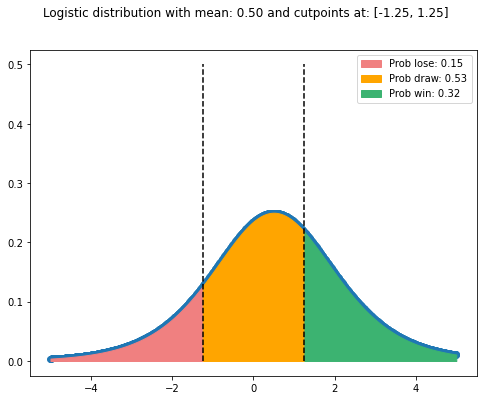

In [3]:
cutpoints = [-1.25, 1.25]
x = np.linspace(-5, 5, 1000)
x_lose = x[x < cutpoints[0]]
x_draw = x[(x >= cutpoints[0]) & (x <= cutpoints[1])]
x_win = x[x > cutpoints[1]]

mu = 0.5  # this is the center of the logistic distribution
log_dist = logistic(mu)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, log_dist.pdf(x))
ax.vlines(cutpoints[0], 0, 0.5, color="black", linestyle="--")
ax.vlines(cutpoints[1], 0, 0.5, color="black", linestyle="--")

prob_lose = log_dist.cdf(cutpoints[0])
prob_win = 1 - log_dist.cdf(cutpoints[1])
prob_draw = 1 - prob_win - prob_lose

ax.fill_between(
    x_lose,
    log_dist.pdf(x_lose),
    color="lightcoral",
    label=f"Prob lose: {prob_lose:.2f}",
)
ax.fill_between(
    x_draw,
    log_dist.pdf(x_draw),
    color="orange",
    label=f"Prob draw: {prob_draw:.2f}",
)
ax.fill_between(
    x_win,
    log_dist.pdf(x_win),
    color="mediumseagreen",
    label=f"Prob win: {prob_win:.2f}",
)
plt.legend()
plt.suptitle(f"Logistic distribution with mean: {mu:.2f} and cutpoints at: {cutpoints}");

It's important to recall that the cutpoints given by `c` apply to all data-points (i.e. games), but the mean of the logistic distribution moves around depending on what the value of 

```
a[player_1_rank[i]] - a[player_2_rank[i]] + w*player_1_white[i]
``` 

evaluates to. 

#### Modelling (relative) ability per player

This is coded in Stan as (in vector notation):

```
a = b * prior_score + sigma_a * raw_a;
```

Thus relative player ability has a prior which is a normal distribution centered at `b * prior_score` (the posterior won't be normal, of course, once we've seen data).

If the prior score contains all the information we need to model relative player ability then `b` would be positive and each element of `a` would be the same. For any given player, if the data contains information over and above the prior then this will be captured by the learned `a` for a player. At the other extreme, if the prior score contains no information for predicting ability then `b` should be close to 0 and each `a` will be estimated separately (not quite, because `sigma_a` is learned across players still).

#### The parameters

* `b`: this is the weight given to the prior score in determining relative player ability, learned across all players.
* `w`: the advantage the player playing as white has that contributes to shifting the center of the logistic distribution likelihood.
* `c`: a vector of length 2 denoting the cutpoints for the logistic distribution.
* `sigma_a`: the uncertainty in modelling per player ability, learned across all players.
* `a`: a vector of length equal to the number of unique players in the training data. Each elements contains a partially-pooled relative ability estimate.

## Implementation details

The main implementation detail is how to construct a prior score which represents the knowledge we have about relative player ability. We can do this as follows:

* In the training data, compute the average Elo rating per player.
* Rank players according to their average Elo rating.
* Assign players a "normalised" so called `prior_score` which assigns higher values to better ranked players, is centered around 0 and lies between -1 and 1.

Whilst we are using the data to construct a "prior" this is not problematic given we withhold a completely distinct test set.

This is constructed as follows:

In [4]:
num_players = 285
raw_prior_score = np.arange(num_players, 0, -1)
prior_score = (raw_prior_score - np.mean(raw_prior_score)) / (
    1 * np.std(raw_prior_score, ddof=1)
)

Note that this is a linear prior score based on rank and as such all differences in the average Elo rating are treated the same i.e. the difference in the prior score for a player ranked one place above another player is the same regardless of their Elo (even if the gap in Elo is huge).

The fact we chose to learn a per player ability creates complexity at test time as we will need to predict for players we've never seen before. How this is done is explained when we [fit the model](2.fit_ordered_logistic_model.ipynb).